In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import robot_vlp.data_collection.communication as c
import robot_vlp.data_collection.experment_processing as p
import keras

from robot_vlp.config import EXPERIMENT_DATA_DIR, RAW_DATA_DIR, VLP_MODELS_DIR, FIGURES_DIR


%load_ext autoreload
%autoreload 2


2025-04-08 19:19:32.661 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


In [2]:
vlp_dataset_path = RAW_DATA_DIR / "experiments/CNC"
output_path = VLP_MODELS_DIR / 'CNC/'

train_df = pd.read_csv(vlp_dataset_path/'cnc_fingerprint_01.csv', delimiter = '|')
train_df = c.process_cnc(train_df)
train_df = c.process_vlp(train_df)

valid_df = pd.read_csv(vlp_dataset_path/'cnc_fingerprint_02.csv', delimiter = '|')
valid_df = c.process_cnc(valid_df)
valid_df = c.process_vlp(valid_df)


X_train = train_df[['L1', 'L2', 'L3', 'L4']].values
y_train = train_df[['cnc_x', 'cnc_y']].values

X_valid = valid_df[['L1', 'L2', 'L3', 'L4']].values
y_valid = valid_df[['cnc_x', 'cnc_y']].values


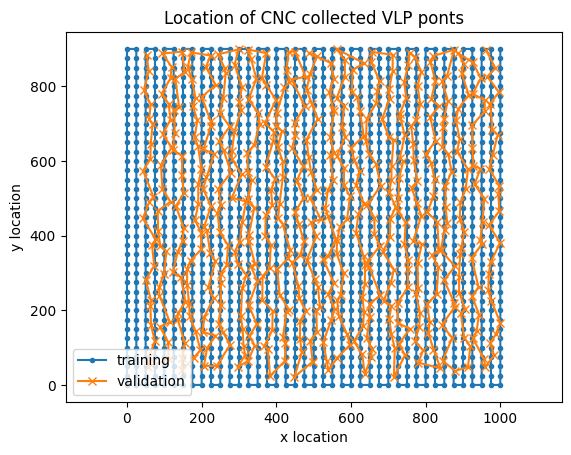

In [3]:
plt.plot(y_train[:,0], y_train[:,1], marker = '.', label = 'training')
plt.plot(y_valid[:,0], y_valid[:,1], label = 'validation', marker = 'x')
plt.axis('equal')
plt.title('Location of CNC collected VLP ponts')
plt.legend()
plt.ylabel('y location')
plt.xlabel('x location')
plt.savefig(FIGURES_DIR/'methodology-CNC_fingerprint.png')

In [4]:
y_train[:,0].min(), y_train[:,0].max()



(0.0, 1000.0)

In [5]:
y_train[:,1].min(), y_train[:,1].max()

(0.0, 900.0)

## Plot RSS curves

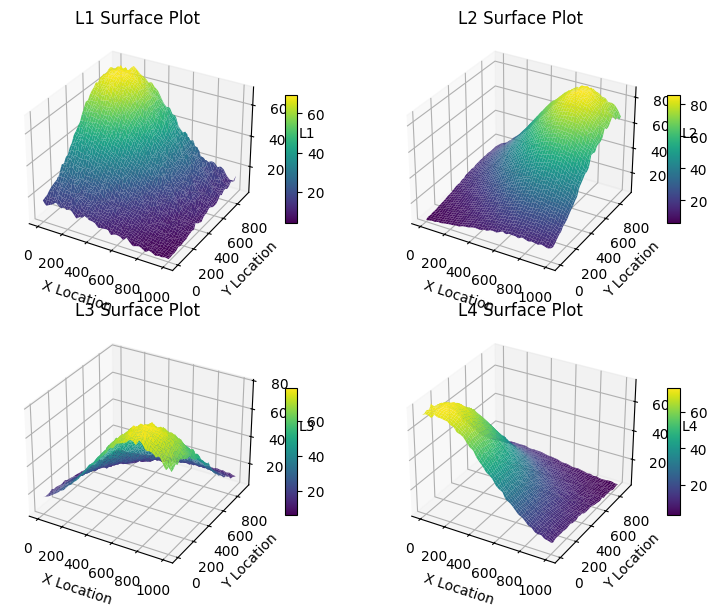

In [6]:

fig = p.plot_surface_irregular(train_df)
fig.savefig(FIGURES_DIR/'methodology-CNC_3d_rss_plot.png')

## Assess model perfomance

In [32]:
import robot_vlp.modeling.gen_cnc_vlp_model as vlp
vlp_models = vlp.load_vlp_models()
vlp_mod = vlp_models['high_acc'] 
pre = vlp_mod.predict(X_valid)
errs = np.sqrt(np.square(pre[:, 0] - y_valid[:, 0]) + np.square(pre[:, 1] - y_valid[:, 1]))

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step

/Users/tyrelglass/miniforge3/envs/robot-vlp/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [33]:
errs.mean(), errs.std()


(20.537785560356802, 11.800149619400864)

In [17]:
errs.mean(), errs.std()

(27.4525201833165, 14.79776086027494)

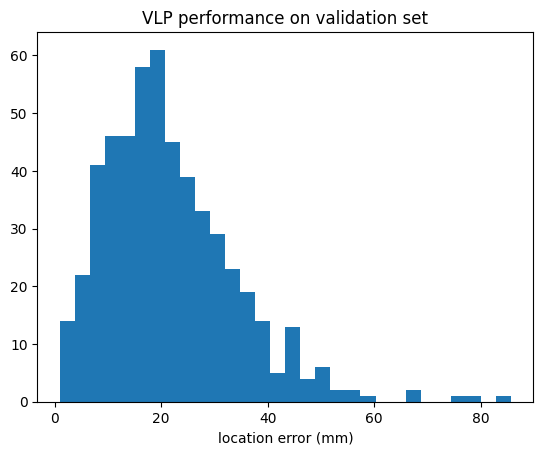

In [29]:
plt.figure()
_ = plt.hist(errs, bins = 30)
plt.title('VLP performance on validation set')
plt.xlabel('location error (mm)')
plt.savefig(FIGURES_DIR/'methodology-CNC_validation_errors.png')

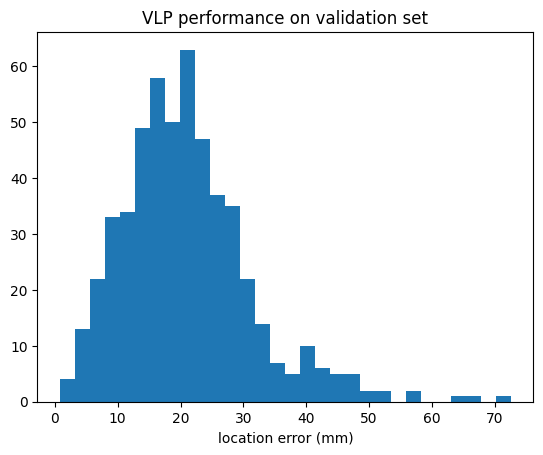

In [52]:
plt.figure()
_ = plt.hist(errs, bins = 30)
plt.title('VLP performance on validation set')
plt.xlabel('location error (mm)')
plt.savefig(FIGURES_DIR/'methodology-CNC_validation_errors.png')

In [35]:
errs.mean()

184.7934941743373

## Tune number of layers and nodes

In [ ]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(hp.Int('units_1', min_value=50, max_value=200, step=50),
                        activation='relu', input_dim=X_train.shape[1]))
        for i in range(hp.Int('num_layers', 1, 3)):  # Choose between 1 and 3 hidden layers
            model.add(Dense(hp.Int(f'units_{i+2}', min_value=50, max_value=200, step=50), 
                            activation='relu'))
        model.add(Dense(2, activation='linear'))  # Output layer
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
        return model

tuner = RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,  # Average over multiple runs
    directory='my_tuning',
    project_name='layer_tuning'
)

# Run the tuner
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=32)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of layers: {best_hps.get('num_layers')}")
print(f"Optimal number of neurons in first layer: {best_hps.get('units_1')}")


Trial 10 Complete [00h 01m 09s]
val_loss: 962.7655029296875

Best val_loss So Far: 954.395751953125
Total elapsed time: 00h 11m 09s
Optimal number of layers: 3
Optimal number of neurons in first layer: 200


In [104]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values

{'units_1': 200, 'num_layers': 3, 'units_2': 50, 'units_3': 100, 'units_4': 50}

## Build model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from keras.callbacks import LearningRateScheduler
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization


def build_and_train_model(partial_data = False):


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Define an exponential decay schedule
    def lr_schedule(epoch, initial_lr=0.01, decay_rate=0.995):
        return initial_lr * (decay_rate ** epoch)
    # Define the Learning Rate Scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Build a simple Keras model
    model = Sequential([
        Dense(200, activation='relu', input_dim=X_train_scaled.shape[1],kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001)),  # You can customize more layers as needed
        BatchNormalization(),
        Dropout(0.1),
        Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.001)),  # You can customize more layers as needed
        BatchNormalization(),
        Dropout(0.1),
        Dense(2, activation='linear')  # Output layer for 2 regression outputs
    ])
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    # Configure early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=30, restore_best_weights=True, verbose=1
    )

    if partial_data == False:
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_valid_scaled, y_valid),
            epochs=10000,
            batch_size=32,
            callbacks=[early_stopping, lr_scheduler],
            verbose=1
        )
    else:
        X_train_partial, _, y_train_partial, _ = train_test_split(
        X_train_scaled, y_train, train_size=0.27, random_state=42
            )
        history = model.fit(
            X_train_partial, y_train_partial,
            validation_data=(X_valid_scaled, y_valid),
            epochs=10000,
            batch_size=32,
            callbacks=[early_stopping, lr_scheduler],
            verbose=1
        )



    # Create a pipeline-like return object
    class CustomPipeline:
        def __init__(self, scaler, model):
            self.scaler = scaler
            self.model = model

        def predict(self, X):
            X_scaled = self.scaler.transform(X)
            return self.model.predict(X_scaled)

    return  CustomPipeline(scaler, model)





In [74]:
k_lst = []
err_lst = []
for k in range(1,40):
    knn = KNeighborsRegressor(n_neighbors=k, weights = 'distance')
    knn.fit(X_train, y_train)
    knn_errs = calc_model_acc(knn, X_valid, y_valid)
    err_lst.append(knn_errs.mean())
    k_lst.append(k)

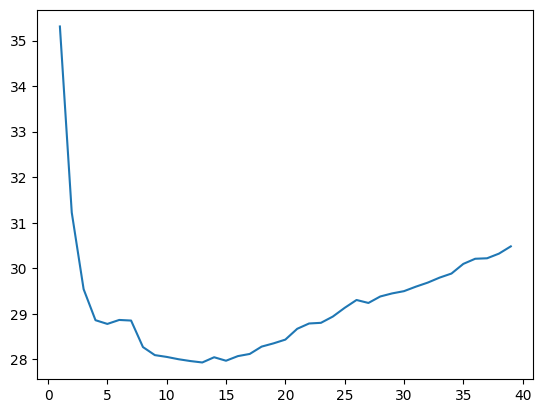

In [75]:
plt.plot(k_lst, err_lst)

## Test model

In [187]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=12, weights = 'distance')
knn.fit(X_train, y_train)

def calc_model_acc(mod, X_test, y_test):
    pre = mod.predict(X_test)
    errs = np.sqrt(
        np.square(pre[:, 0] - y_test[:, 0]) + np.square(pre[:, 1] - y_test[:, 1])
        )
    return errs
mlp_high_acc_errs = calc_model_acc(mlp_high_acc, X_valid, y_valid)
mlp_low_acc_errs = calc_model_acc(mlp_low_acc, X_valid, y_valid)
knn_errs = calc_model_acc(knn, X_valid, y_valid)

print("mlp low acc mean error of: " + str(mlp_low_acc_errs.mean()))
print("mlp high acc mean error of: " + str(mlp_high_acc_errs.mean()))

print("knn mean error of: " + str(knn_errs.mean()))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
mlp low acc mean error of: 49.79957798137764
mlp high acc mean error of: 24.78094986561652
knn mean error of: 27.963467569958407


In [11]:
df[['pre_x', 'pre_y']] = mlp.predict(df[['peak_1000Hz', 'peak_3000Hz', 'peak_5000Hz', 'peak_7000Hz']].values)

df['vlp_err'] = np.sqrt(np.square(df['pre_x'] - df['room_x']) + np.square(df['pre_y'] - df['room_y']))

/Users/tyrelglass/miniforge3/envs/robot-vlp/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


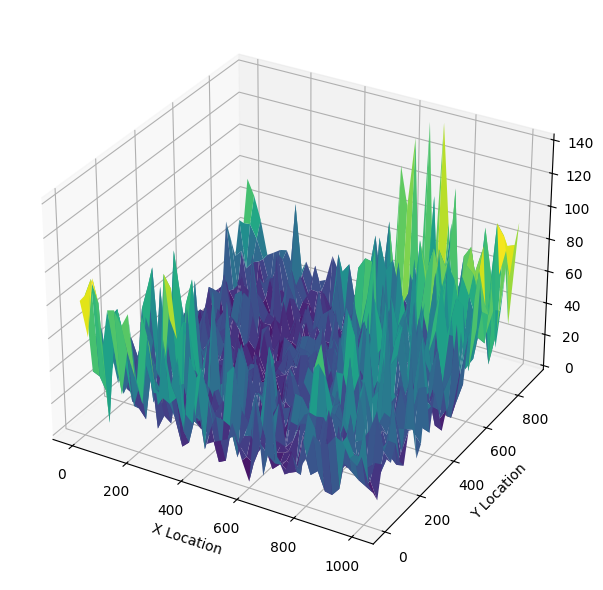

In [13]:
# Creating 4 subplots for each target peak column
fig = plt.figure(figsize=(8, 6))


ax = fig.add_subplot(111, projection='3d')  

# Prepare the grid for surface plotting
X, Y = np.meshgrid(df["room_x"].unique(), df["room_y"].unique())
Z = df.pivot_table(index='room_y', columns='room_x', values='vlp_err').values

# # Plot the surface
ax.plot_surface(X, Y, Z, cmap='viridis')

# Label the axes

ax.set_xlabel('X Location')
ax.set_ylabel('Y Location')


# Adjust layout and show the plot
plt.tight_layout()
plt.show()